In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE

In [2]:
rest = pd.read_csv('/Volumes/Database/Research/ozone-budget/result_df_UKESM1_3_0_NN_width_64_dropout_0.1_90.csv')
data = pd.read_csv('/Volumes/Database/Research/C7 Multivariate analysis/UKESM1-0-LL_diag_2014(1217).csv')

In [3]:
rest['tas'] = data['tas']
rest['pan'] = data['pan']
rest['photo1d'] = data['photo1d']

rest['o3_mole'] = rest['o3']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['no_mole'] = rest['no']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['no2_mole'] = rest['no2']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['oh_mole'] = rest['oh']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['h2o_mole'] = rest['h2o']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['hno3_mole'] = rest['hno3']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['pan_mole'] = rest['pan']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)

rest['ho2_mole'] = rest['HO₂']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['ch3o2_mole'] = rest['CH₃O₂']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)
rest['o1d_mole'] = rest['O¹D']*1.01325*10**5/rest['tas']*7.243*10**7*(10**9)

rest['k_ho2_ho2'] = 2.2*10**(-13)*np.exp(600/rest['tas'])
rest['k_oh_no2'] = 6.5*10**(-11)
rest['k_no_ho2'] = data['k_no_ho2']
rest['k_no_ch3o2'] = data['k_no_ch3o2']
rest['k_o1d_h2o'] = data['k_o1d_h2o']
rest['k_o3_ho2'] = data['k_o3_ho2']
rest['k_o3_oh'] = data['k_o3_oh']

In [4]:
rest['P1_HO2_NO'] = rest['k_no_ho2']*rest['no_mole']*rest['ho2_mole']
rest['P2_CH3O2_NO'] = rest['k_no_ch3o2']*rest['no_mole']*rest['ch3o2_mole']

rest['P3_O1D_H2O'] = rest['o1d_mole']*rest['h2o_mole']*rest['k_o1d_h2o']
rest['P4_OH_O3'] = rest['k_o3_oh']*rest['oh_mole']*rest['o3_mole']
rest['P5_HO2_O3'] = rest['k_o3_ho2']*rest['ho2_mole']*rest['o3_mole']

In [5]:
rest['P1'] = rest['P1_HO2_NO']/rest['PO₃̂']
rest['P2'] = rest['P2_CH3O2_NO']/rest['PO₃̂']

rest['P3'] = rest['P3_O1D_H2O']/rest['LO₃̂']
rest['P4'] = rest['P4_OH_O3']/rest['LO₃̂']
rest['P5'] = rest['P5_HO2_O3']/rest['LO₃̂']

In [6]:
rest['HO2_OH'] = rest['ho2_mole']/rest['oh_mole']
rest['alpha'] = rest['P3_O1D_H2O']/rest['o3_mole']/rest['photo1d']

In [7]:
rest['alpha'].describe()

count    9.720000e+05
mean              inf
std               NaN
min      6.984042e-06
25%      6.848949e-02
50%      1.197735e-01
75%      1.607564e-01
max               inf
Name: alpha, dtype: float64

In [8]:
country = pd.read_csv('/Users/csuen/Desktop/PhD/Maps/country_province_state_2*2.csv')
rest = rest.merge(country, how = 'left', left_on = ['longitude','latitude'], right_on = ['longitude','latitude'])
rest = rest.drop(['province','state'], axis=1)
rest_land = rest.dropna()
rest_land = rest_land[rest_land['latitude'] >= -60]

In [9]:
rest_land['PO₃̂'].mean(), rest_land['P1_HO2_NO'].mean(), rest_land['P2_CH3O2_NO'].mean()

(3836916.172496508, 1941827.7055261896, 1838782.4488314178)

In [10]:
rest_land['LO₃̂'].mean(), rest_land['P3_O1D_H2O'].mean(), rest_land['P4_OH_O3'].mean(), rest_land['P5_HO2_O3'].mean()

(944654.4765666942, 784683.9529318765, 91550.16646706332, 3111.153444386024)

In [11]:
rest_land['HO2_OH'].describe()

count    232140.000000
mean        581.704834
std        1708.856969
min           0.015582
25%          50.165244
50%         162.610560
75%         497.003324
max       44982.195426
Name: HO2_OH, dtype: float64

In [12]:
rest_land.replace([np.inf, -np.inf], 0, inplace=True)
rest_land['alpha'].mean()

0.12327659688105111

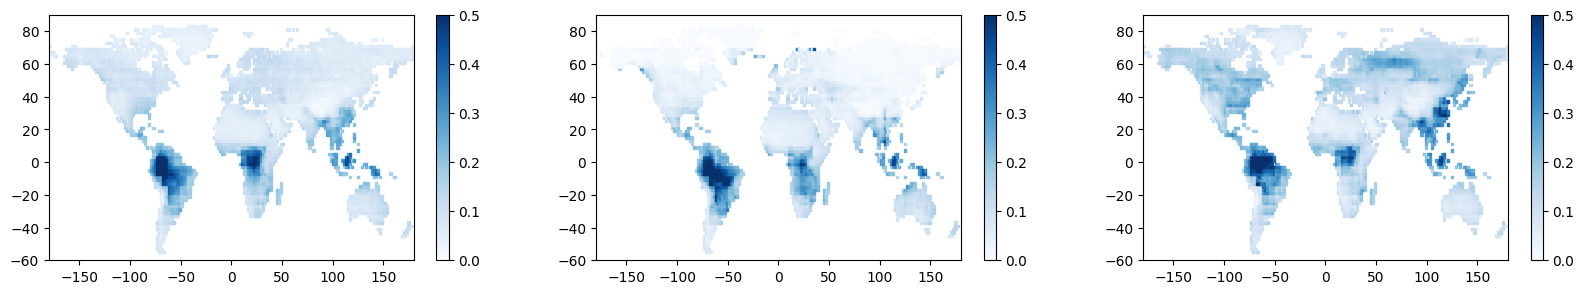

In [22]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(20, 3.25), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
rest_land['loc'] = rest_land['longitude']*1000 + rest_land['latitude']
rest_map = rest_land.groupby(['loc']).median()

cm = plt.cm.get_cmap('Blues')
x = rest_map['longitude']
y = rest_map['latitude']
z = rest_map['alpha']
sc = plt.scatter(x, y, c=z, marker="s", vmin=0, vmax=0.5, s=3, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-60, 90])
plt.colorbar(sc)

plt.subplot(1,3,2)
rest_map = rest_land[rest_land['t'] == 1]
x = rest_map['longitude']
y = rest_map['latitude']
z = rest_map['alpha']
sc = plt.scatter(x, y, c=z, marker="s", vmin=0, vmax=0.5, s=3, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-60, 90])
plt.colorbar(sc)

plt.subplot(1,3,3)
rest_map = rest_land[rest_land['t'] == 7]
x = rest_map['longitude']
y = rest_map['latitude']
z = rest_map['alpha']
sc = plt.scatter(x, y, c=z, marker="s", vmin=0, vmax=0.5, s=3, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-60, 90])
plt.colorbar(sc)